In [2]:
import os
import gzip
import pickle
import numpy as np
import torch
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
from tqdm import tqdm
from ebm.model import Network
import networkx as nx
from ebm.external_world import ExternalWorld, MNISTExternalWorld

from ebm.train_model import *


def pi(s):
    return torch.clamp(s, 0.0, 1.0)

class ExternalWorld:
    def __init__(self, x_values, y_values):
        self.x = torch.tensor(x_values, dtype=torch.float32)
        self.y = torch.tensor(y_values, dtype=torch.int64)
        self.size_dataset = len(self.x)



In [3]:
def train_net(net: Network, plot_graph = False):
    history = {"Energy": [], "Cost": [], "Error": []}
    epochs, batch_size = net.hyperparameters["n_epochs"], net.hyperparameters["batch_size"]
    n_batches = net.dataset_size // batch_size
    n_it_neg, n_it_pos, alphas = net.hyperparameters["n_it_neg"], net.hyperparameters["n_it_pos"], net.hyperparameters["alphas"]


    snapshot_epochs = np.linspace(0, epochs - 1, 5, dtype=int)
    # with tqdm(total=epochs, desc="Training Progress", unit="epoch") as epoch_bar:
    for epoch in range(epochs):
        for i in range(n_batches):
            if(i>0):
                for j in range(0,len(net.layers)):

                    net.layers[j] = 0 * net.layers[j]
            net.biases[-1] *=0
            net.weights[-1] = torch.tensor([[-1.,1.]]) 
            for j in range(0,len(net.persistent_particles)):
                net.persistent_particles[j] = net.persistent_particles[j] * 0 
            net.update_mini_batch_index(i)
            net.negative_phase(n_it_neg)
            net.positive_phase(n_it_pos, *alphas)

            # for j in range(0,len(net.biases)-2):
            #     net.biases[j]*= 0 
            net.biases[-1] *=0
            net.weights[-1] = torch.tensor([[-1.,1.]]) 
            for j in range(0,len(net.persistent_particles)):
                net.persistent_particles[j] = net.persistent_particles[j] * 0 
            # for j in range

            # net.persistent_particles *=0
            
            # = [
            #     torch.tensor([[-1.,  1.],
            #                 [ 1., -1.]]),           # Input → Hidden
            #     torch.tensor([[1.],
            #                 [1.]]),            # Hidden → Output
            #     torch.tensor([[-1.,1.]])    # Final classifier layer (if used)
            # ]


        # Measure and log
        E, C, error = net.measure()
        history["Energy"].append(E)
        history["Cost"].append(C)
        history["Error"].append(error * 100)

        # Update progress bar description instead of using set_postfix()
        # epoch_bar.set_description(f"Epoch {epoch+1}/{epochs} | E={E:.2f} C={C:.5f} Error={error*100:.2f}%")
        # epoch_bar.update(1)
        if(plot_graph):
            if epoch in snapshot_epochs:
                if(history["Error"][-1]< 0.001):
                    plot_network_weights(net, epoch)
    # Plot results
    res = np.mean(history["Error"][-4:])
    if(plot_graph and res < 0.001):
        fig, axes = plt.subplots(1, 3, figsize=(18, 4))
        for ax, (key, color) in zip(axes, [("Energy", "blue"), ("Cost", "orange"), ("Error", "red")]):
            ax.plot(history[key], label=key, color=color)
            ax.set_title(f"{key} over Epochs")
        plt.tight_layout()
        plt.show()
    return res

In [4]:
import torch.nn as nn
# XOR dataset
xor_x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=np.float32)
xor_y = np.array([0, 1, 1, 0], dtype=np.int64)

# ExternalWorld instance with XOR data
xor_world = ExternalWorld(xor_x, xor_y)


  0%|          | 0/64 [00:00<?, ?it/s]

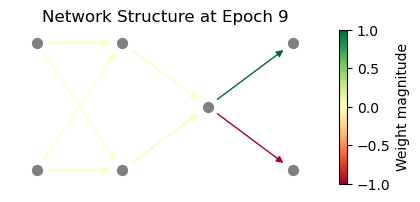

 22%|██▏       | 14/64 [00:00<00:00, 109.80it/s]

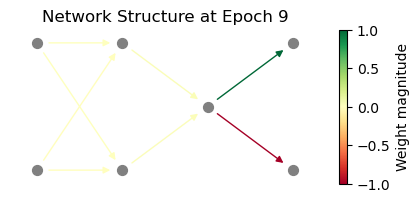

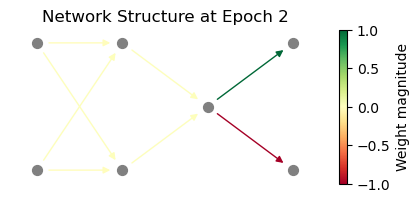

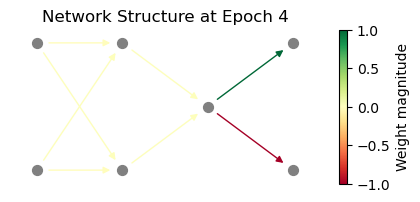

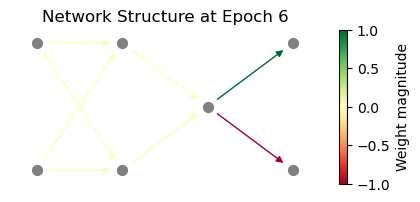

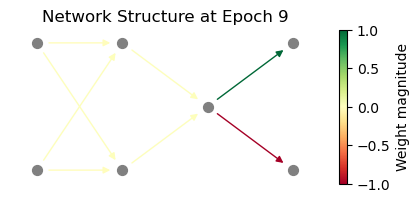

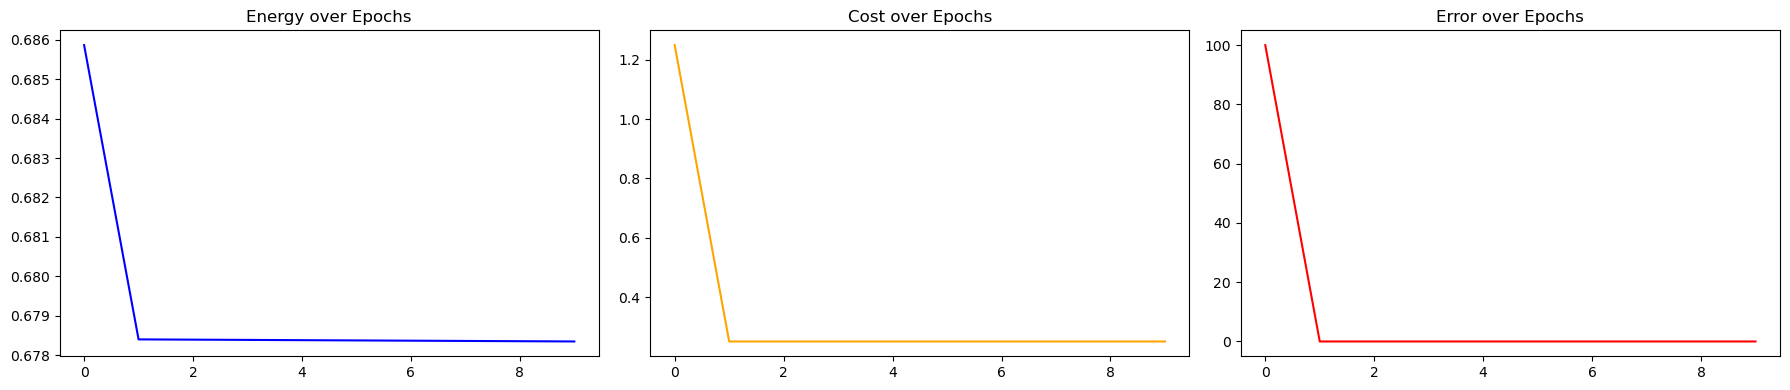

 39%|███▉      | 25/64 [00:00<00:00, 43.55it/s] 

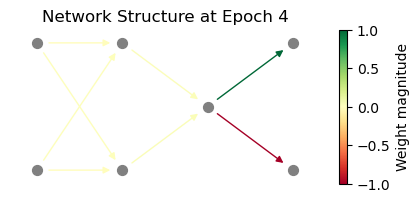

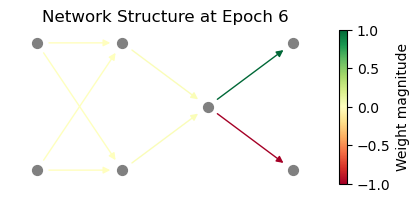

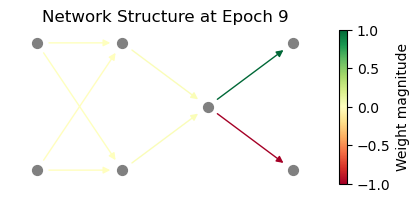

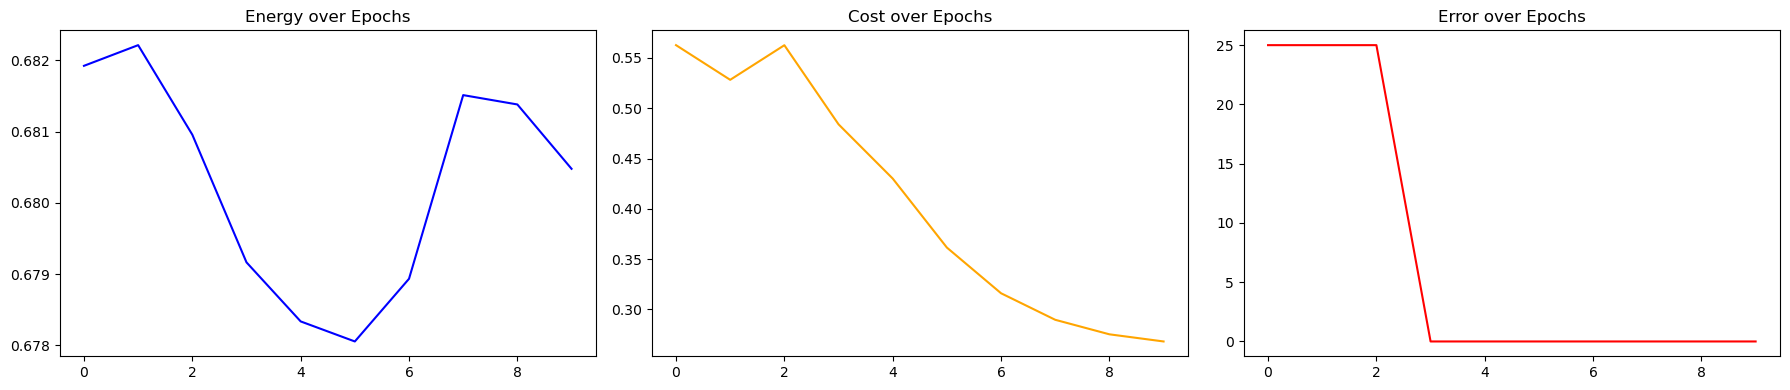

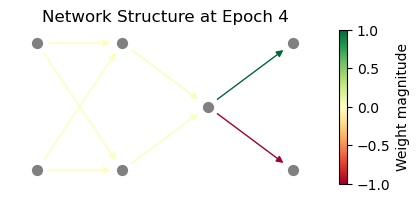

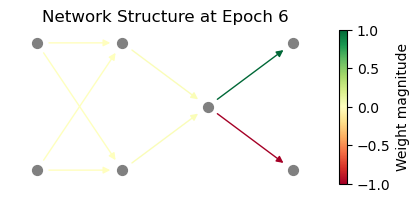

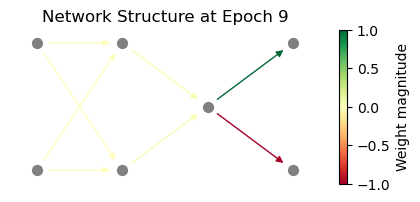

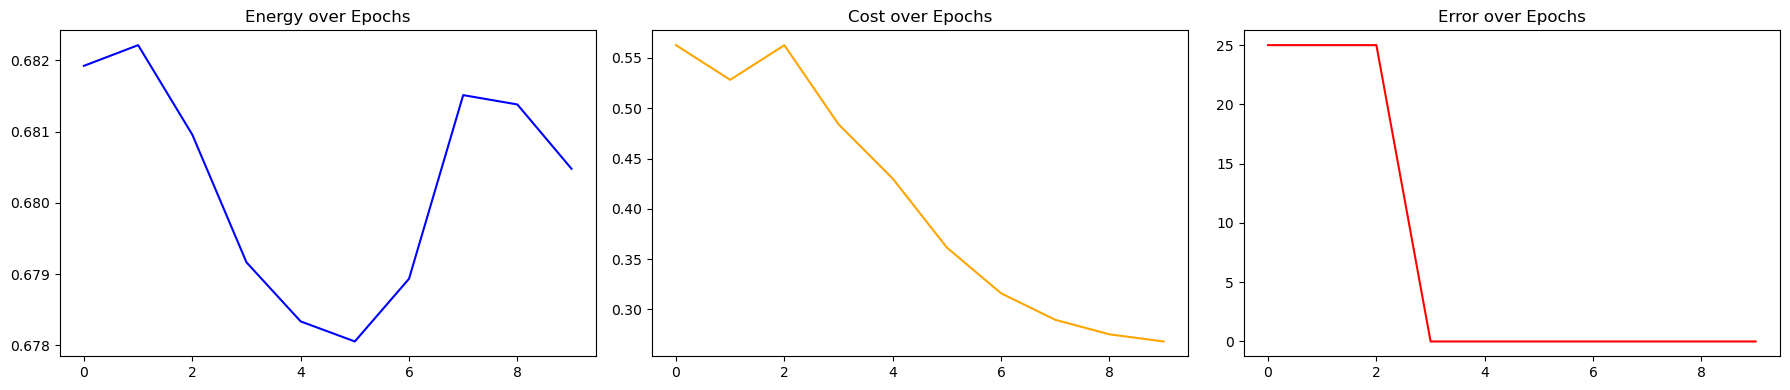

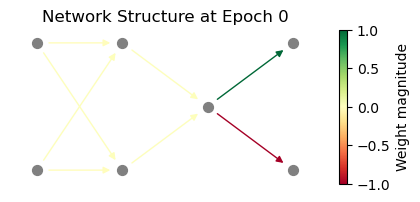

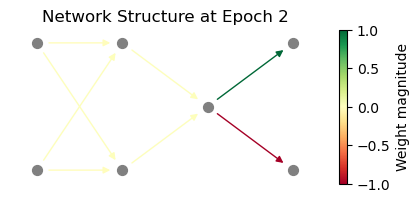

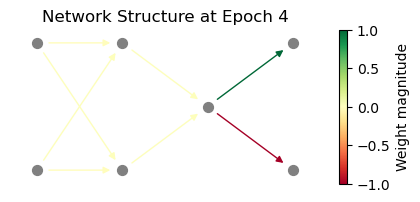

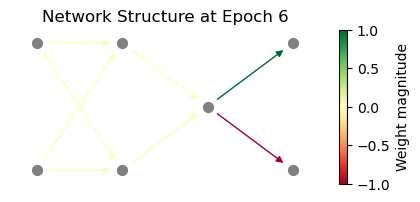

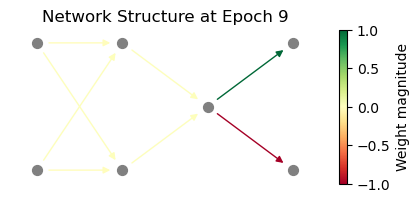

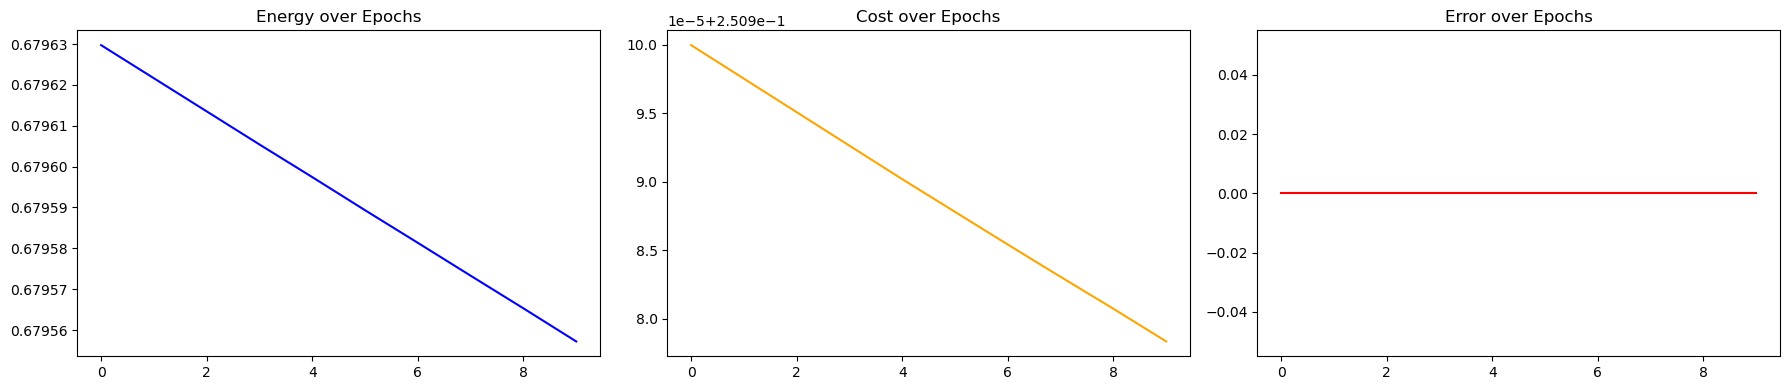

 50%|█████     | 32/64 [00:01<00:01, 16.36it/s]

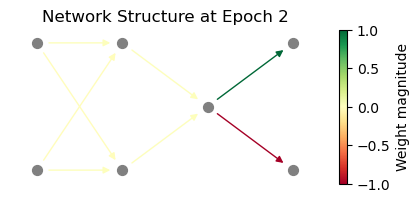

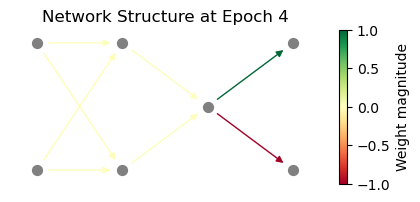

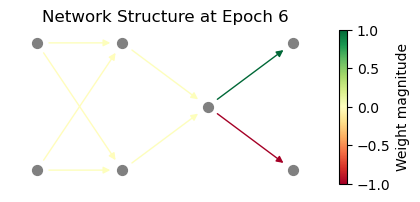

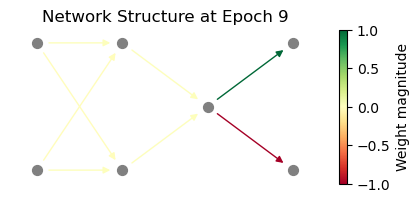

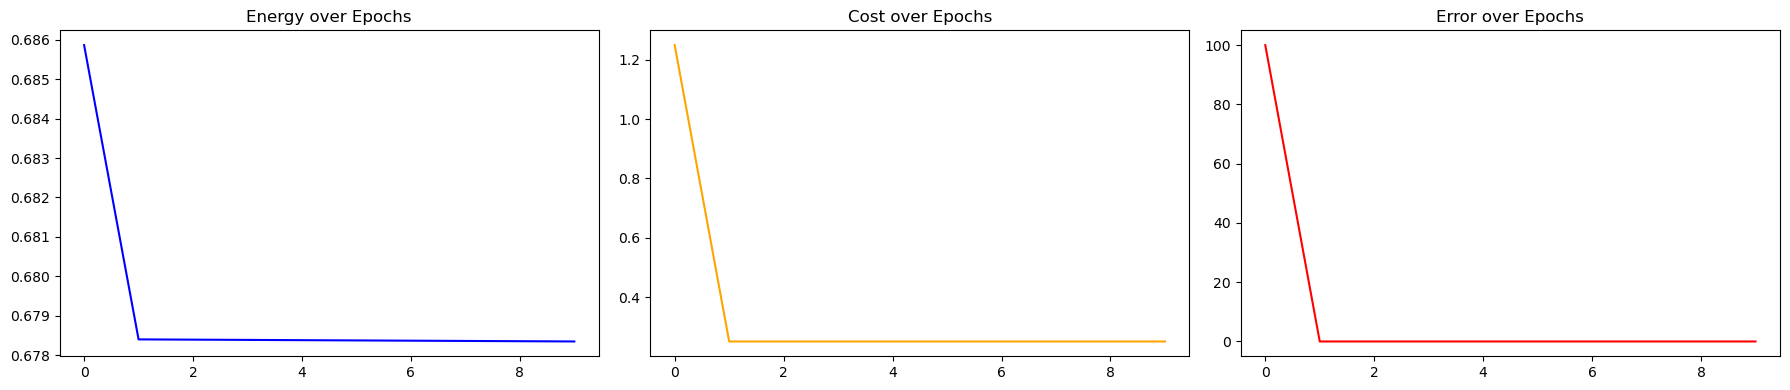

 58%|█████▊    | 37/64 [00:01<00:01, 16.11it/s]

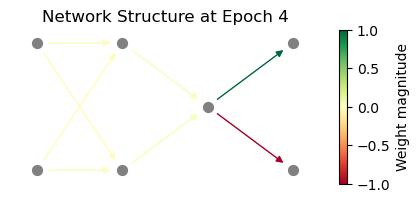

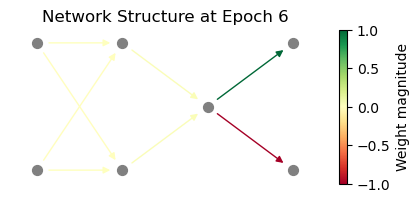

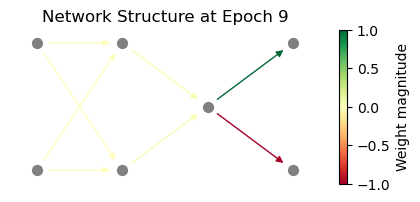

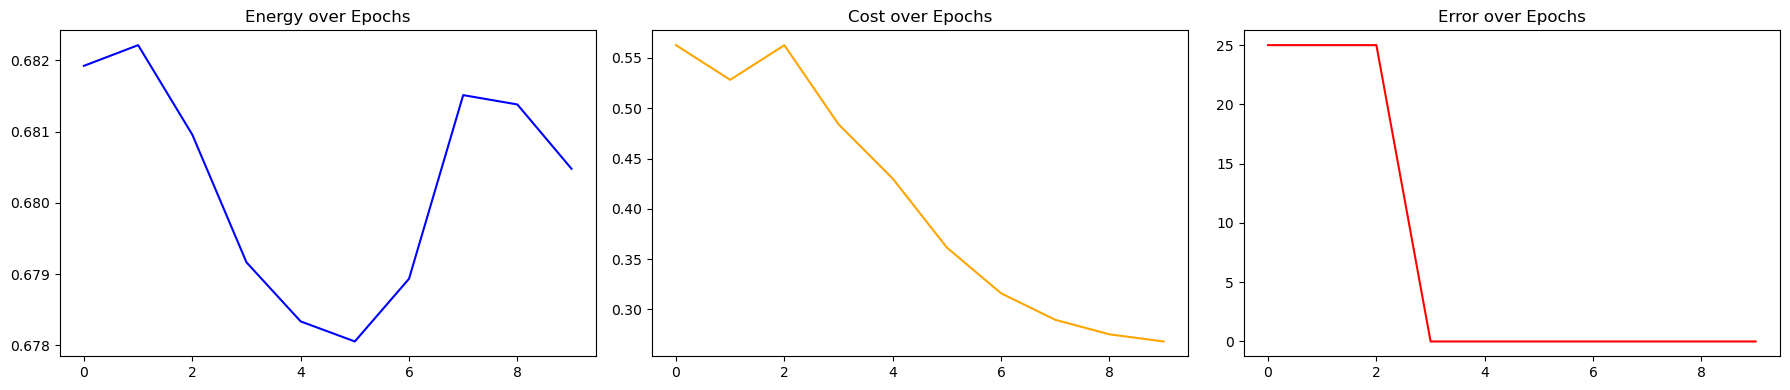

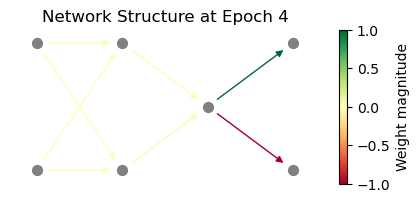

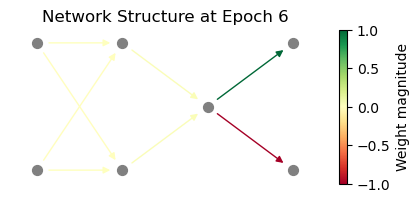

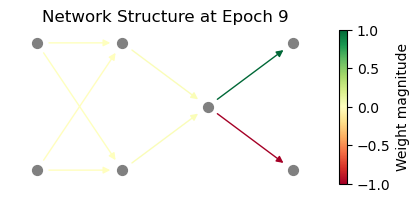

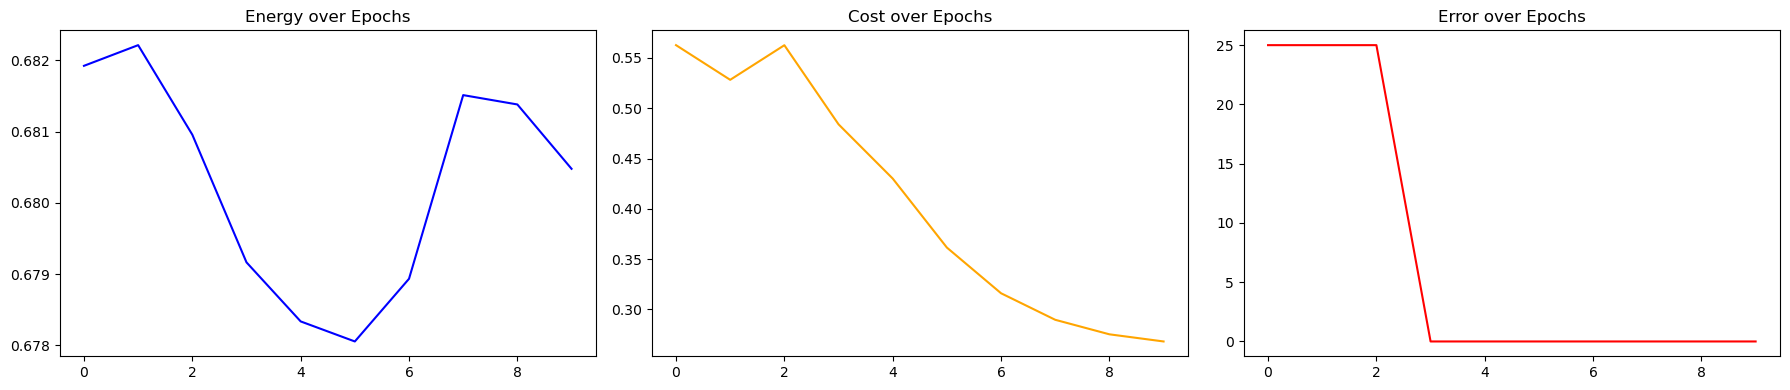

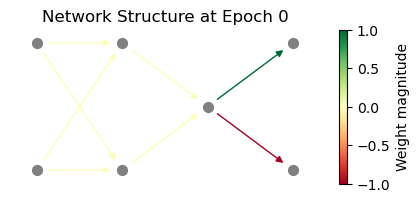

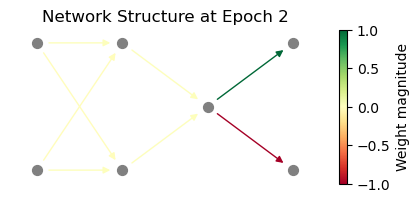

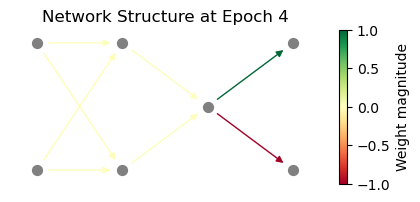

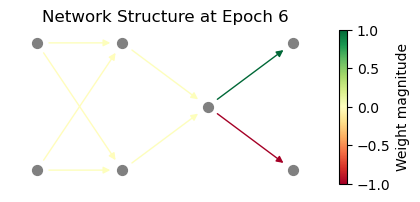

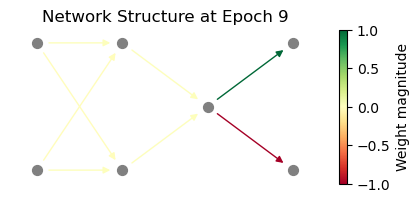

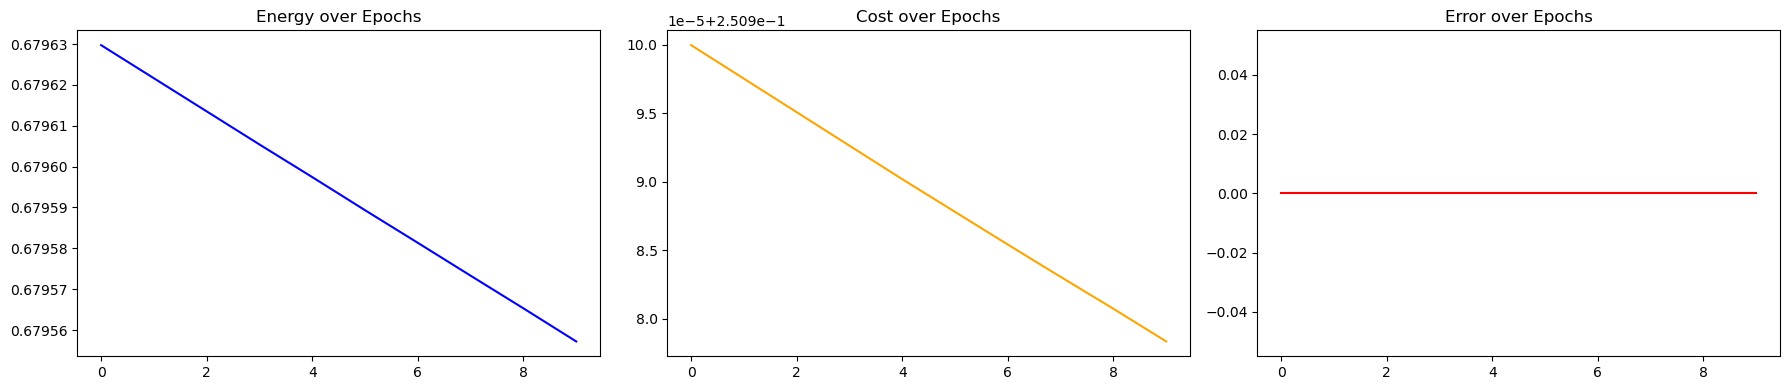

 62%|██████▎   | 40/64 [00:02<00:02,  9.17it/s]

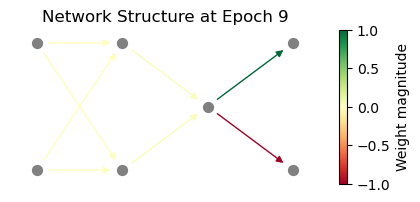

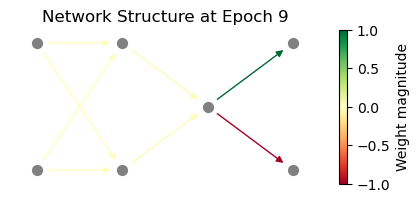

100%|██████████| 64/64 [00:03<00:00, 21.21it/s]


In [7]:
import itertools
import numpy as np
import torch

# Generate all possible combinations of -1, 0, 1 for 9 parameters
all_inits = list(itertools.product([-0.01,0.01], repeat=6))

results = []


errors = {}

lst = [a for a in enumerate(all_inits)]

for i, init in tqdm(lst):
    trials = 1
    error_counter = 0 
    for t in range(0, trials):
        xor_net = Network(
            name=f"xor_trial_{i}",
            external_world=xor_world,
            hyperparameters={
                "hidden_sizes": [2, 1],
                "output_size": 2,
                "batch_size": 4,
                "n_epochs": 10,  # just test untrained net
                "n_it_neg": 1,
                "n_it_pos": 1,
                "alphas": [0.1, 0.1, 0.1],
                "activation": "relu"
            }
        )

        # Unpack init into weights and biases
        init = torch.tensor(init, dtype=torch.float32)
        W0 = init[:4].reshape(2, 2)
        # b1 = init[4:6]
        W1 = init[4:6].reshape(2, 1)
        # b2 = init[8:]

        with torch.no_grad():
            xor_net.weights[0][:] = W0
            # xor_net.biases[1][:] = b1
            xor_net.weights[1][:] = W1
            # xor_net.biases[2][:] = b2

        # print(init)

        # Evaluate the net — assume this function exists
        error_counter+= train_net(xor_net, plot_graph= True)

    errors[init] = (error_counter / trials, xor_net.weights[0][:] , xor_net.weights[1][:], xor_net.weights, xor_net.biases, xor_net.persistent_particles)
    # print(xor_net.biases)
    # print(xor_net.weights)

    # results.append((i, acc.item(), init.numpy()))


In [8]:
zero_error_weights = torch.stack([k for k in errors if errors[k][0] < 0.001])

zero_error_weights

tensor([[-0.0100,  0.0100,  0.0100, -0.0100, -0.0100, -0.0100],
        [-0.0100,  0.0100,  0.0100, -0.0100, -0.0100,  0.0100],
        [-0.0100,  0.0100,  0.0100, -0.0100,  0.0100, -0.0100],
        [-0.0100,  0.0100,  0.0100, -0.0100,  0.0100,  0.0100],
        [ 0.0100, -0.0100, -0.0100,  0.0100, -0.0100, -0.0100],
        [ 0.0100, -0.0100, -0.0100,  0.0100, -0.0100,  0.0100],
        [ 0.0100, -0.0100, -0.0100,  0.0100,  0.0100, -0.0100],
        [ 0.0100, -0.0100, -0.0100,  0.0100,  0.0100,  0.0100]])

In [9]:
import torch

def relu(x):
    return max(0.0, x)

def weights_to_formula_and_check(w):
    """
    Given 6D weight tensor, return:
    - ReLU formula string
    - Evaluation on all 4 (x1, x2) inputs
    - Whether it implements XOR, XNOR, or neither
    """
    w1, w2, w3, w4, w5, w6 = [float(x) for x in w]

    # Print formula
    formula = [
        f"h1 = ReLU({w2:.2f} * x1 + {w4:.2f} * x2)",
        f"h2 = ReLU({w1:.2f} * x1 + {w3:.2f} * x2)",
        f"y  = {w6:.2f} * h1 + {w5:.2f} * h2"
    ]

    results = {}
    for x1 in [0, 1]:
        for x2 in [0, 1]:
            h1 = relu(w2 * x1 + w4 * x2)
            h2 = relu(w1 * x1 + w3 * x2)
            y = w6 * h1 + w5 * h2
            results[(x1, x2)] = y
            print(x1, x2, results[(x1,x2)])

    # Expected values
    xor = {(0,0): 0, (0,1): 1, (1,0): 1, (1,1): 0}
    xnor = {k: 1 - v for k, v in xor.items()}

    def match(truth):
        return all(abs(results[k] - truth[k]) <= 0.1 for k in results)

    if match(xor):
        verdict = "XOR"
    elif match(xnor):
        verdict = "XNOR"
    else:
        verdict = "Neither"

    return formula + [results] + [verdict]


In [10]:
f_weights = []

for initial_weights, (final_error, w_in, w_out, wall, ball, pp) in [(k, errors[k]) for k in errors if errors[k][0] < 0.001]:
    w_in = w_in.numpy()
    w_out = w_out.numpy()

    final_weights = np.concatenate([w_in.flatten(), w_out.flatten()])
    f_weights.append((final_weights, wall, ball))

In [13]:


for wt in f_weights:
    w = wt[0]
    print()
    result = weights_to_formula_and_check(w)
    for r in result:
        print(r)
    print("weights", w)
    # print(w)
    print("all weights", wall)
    print("bias", ball)
    print("pers particles", pp)


0 0 0.0
0 1 0.00015152271262355854
1 0 0.00015152271262355854
1 1 0.0
h1 = ReLU(0.01 * x1 + -0.01 * x2)
h2 = ReLU(-0.01 * x1 + 0.01 * x2)
y  = 0.02 * h1 + 0.02 * h2
{(0, 0): 0.0, (0, 1): 0.00015152271262355854, (1, 0): 0.00015152271262355854, (1, 1): 0.0}
Neither
weights [-0.01003563  0.01003563  0.01003563 -0.01003563  0.01509847  0.01509847]
all weights [tensor([[ 0.0100, -0.0100],
        [-0.0100,  0.0100]]), tensor([[0.0102],
        [0.0102]]), tensor([[-1.,  1.]])]
bias [tensor([0., 0.]), tensor([-3.7253e-10, -3.7253e-10]), tensor([0.]), tensor([0., 0.])]
pers particles [tensor([[-0., -0.],
        [-0., 0.],
        [0., -0.],
        [-0., -0.]]), tensor([[-0.],
        [0.],
        [0.],
        [-0.]]), tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])]

0 0 0.0
0 1 0.0002884197249813994
1 0 0.0
1 1 0.0
h1 = ReLU(-0.01 * x1 + 0.01 * x2)
h2 = ReLU(-0.00 * x1 + 0.00 * x2)
y  = 0.03 * h1 + 0.03 * h2
{(0, 0): 0.0, (0, 1): 0.0002884197249813994, (1, 0): 0

In [9]:
errors

{tensor([-1., -1., -1., -1., -1., -1.]): (100.0,
  tensor([[-1.2500, -1.2500],
          [-1.2500, -1.2500]]),
  tensor([[-1.],
          [-1.]]),
  [tensor([[-1.2500, -1.2500],
           [-1.2500, -1.2500]]),
   tensor([[-1.],
           [-1.]]),
   tensor([[-1.,  1.]])],
  [tensor([0., 0.]), tensor([0., 0.]), tensor([0.]), tensor([0., 0.])],
  [tensor([[0., 0.],
           [0., 0.],
           [0., 0.],
           [0., 0.]]),
   tensor([[0.],
           [0.],
           [0.],
           [0.]]),
   tensor([[0., 0.],
           [0., 0.],
           [0., 0.],
           [0., 0.]])]),
 tensor([-1., -1., -1., -1., -1.,  1.]): (100.0,
  tensor([[-1.2500, -1.0000],
          [-1.2500, -1.0000]]),
  tensor([[-1.],
          [ 1.]]),
  [tensor([[-1.2500, -1.0000],
           [-1.2500, -1.0000]]),
   tensor([[-1.],
           [ 1.]]),
   tensor([[-1.,  1.]])],
  [tensor([0., 0.]), tensor([0., 0.]), tensor([0.]), tensor([0., 0.])],
  [tensor([[0., 0.],
           [0., 0.],
           [0., 0.],

In [10]:
import torch
import pandas as pd
import numpy as np

# Prepare data for DataFrame
data_rows = []

for initial_weights, (final_error, w_in, w_out) in [(k, errors[k]) for k in errors if errors[k][0] < 0.001]:
    w_in = w_in.numpy()
    w_out = w_out.numpy()

    final_weights = np.concatenate([w_in.flatten(), w_out.flatten()])

    # Thresholding to {-1, 0, 1}
    thresholded = np.zeros_like(final_weights)
    thresholded[final_weights > 0.0005] = 1
    thresholded[final_weights < -0.0005] = -1

    def oppose(a, b):
        return np.sign(a) != np.sign(b) and a != 0 and b != 0

    row = {
        'final_error': final_error,
    }

    for i in range(6):
        row[f'initial_w{i}'] = initial_weights[i].item()
        row[f'final_w{i}'] = final_weights[i]
        row[f'thresh_w{i}'] = thresholded[i]

    # All pairwise oppositions among w0–w5
    for i in range(6):
        for j in range(i+1, 6):
            row[f'opp_{i}{j}'] = oppose(final_weights[i], final_weights[j])

    data_rows.append(row)

df_weights = pd.DataFrame(data_rows)

df_weights

ValueError: too many values to unpack (expected 3)

In [ ]:
xor_net = Network(
            name=f"xor_trial_{i}",
            external_world=xor_world,
            hyperparameters={
                "hidden_sizes": [2, 1],
                "output_size": 2,
                "batch_size": 4,
                "n_epochs": 20,  # just test untrained net
                "n_it_neg": 1,
                "n_it_pos": 1,
                "alphas": [0,0,0],
                             "activation": "relu"
            }
        )

        # Unpack init into weights and biases

[-1.   ,      1.   ,      1.    ,    -1.     ,    1.0000024 , 1.0000024]
init = torch.tensor(init, dtype=torch.float32)
# W0 = init[:4].reshape(2, 2)
# # b1 = init[4:6]
# W1 = init[4:6].reshape(2, 1)
# b2 = init[8:]

with torch.no_grad():
    xor_net.weights[0][:] = init[0:4].reshape(2, 2) #torch.tensor([-1, -0.25, 0.25, 1]).reshape(2, 2)
    # xor_net.biases[1][:] = b1
    xor_net.weights[1][:] = init[4:6].reshape(2, 1)# torch.tensor([-1, 1]).reshape(2, 1)
    # xor_net.biases[2][:] = b2

# print(init)
            # h1 = relu(w2 * x1 + w4 * x2)
            # h2 = relu(w1 * x1 + w3 * x2)
            # y = w6 * h1 + w5 * h2
    

# h1 = w2 x1 + w4 x2 
# h2 = w1 x1 + w3 x2


# y = w6 h1 + w5 h2


#h1 = w4 x1 + w2 x2 
#h1 = w1 x2 + w3 x1 

# Evaluate the net — assume this function exists
print('err', train_net(xor_net, plot_graph= False))
print("Total layer sum:", sum(l.sum() for l in xor_net.layers).item())
print("Total weight sum:", sum(w.sum() for w in xor_net.weights).item())
print("Total bias sum:", sum(b.sum() for b in xor_net.biases).item())

print(xor_net.persistent_particles)




err 75.0
Total layer sum: 5.4999847412109375
Total weight sum: 6.0
Total bias sum: 0.0
[tensor([[-0., -0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]]), tensor([[-0.],
        [-0.],
        [-0.],
        [0.]]), tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])]


/var/folders/q0/hw11rnjs0g1cnny7p5swsnv40000gn/T/ipykernel_68167/2301026332.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  init = torch.tensor(init, dtype=torch.float32)


[tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]]), tensor([[-0.2500, -0.2500],
        [ 0.7500, -0.2500],
        [-0.2500,  0.7500],
        [-0.2500, -0.2500]]), tensor([[-0.5000],
        [ 0.5000],
        [ 0.5000],
        [-0.5000]]), tensor([[0.5000, 0.0000],
        [0.0000, 0.5000],
        [0.0000, 0.5000],
        [0.5000, 0.0000]])]
[tensor([[-1.0375,  0.0125],
        [ 0.0125, -1.0375]]), tensor([[1.0000],
        [1.0000]]), tensor([[-1.,  1.]])]
[tensor([0., 0.]), tensor([0., 0.]), tensor([0.]), tensor([0., 0.])]


In [ ]:




100: [tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]]), tensor([[-0.2498, -0.2498],
        [ 0.7494, -0.2498],
        [-0.2498,  0.7494],
        [-0.2498, -0.2498]]), tensor([[-0.5000],
        [ 0.5000],
        [ 0.5000],
        [-0.5000]]), tensor([[0.0000, 0.0000],
        [0.6353, 0.3973],
        [0.6353, 0.3973],
        [0.0000, 0.0000]])]
[tensor([[-1.0375,  0.0125],
        [ 0.0125, -1.0375]]), tensor([[1.0000],
        [1.0000]]), tensor([[-1.,  1.]])]
[tensor([0., 0.]), tensor([0., 0.]), tensor([0.]), tensor([0., 0.])]

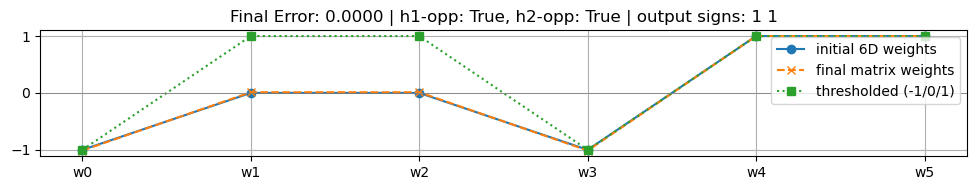

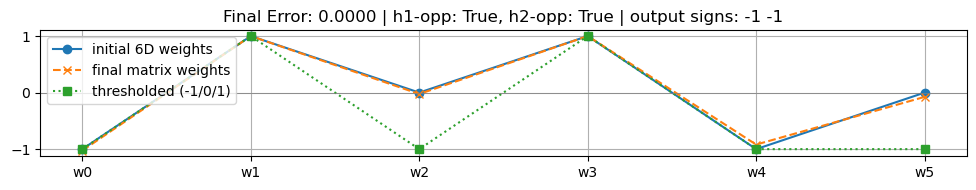

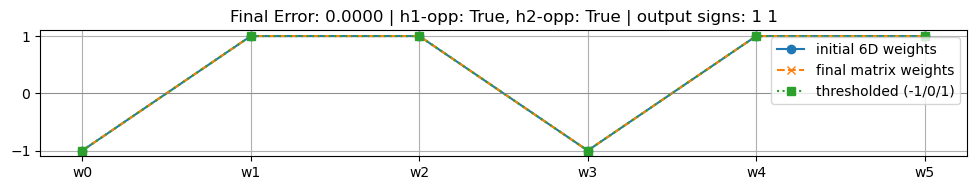

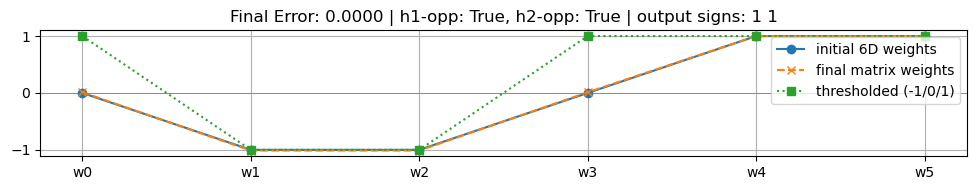

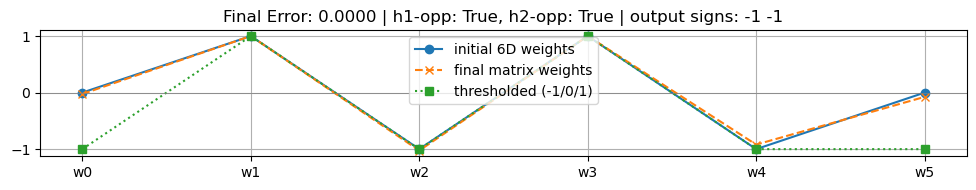

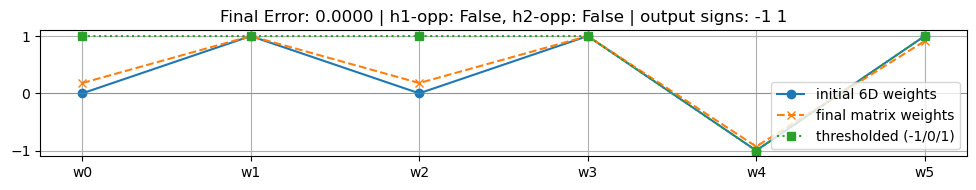

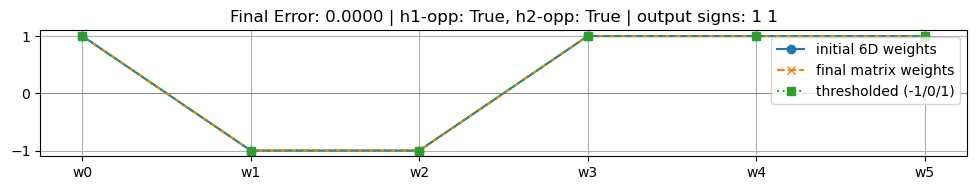

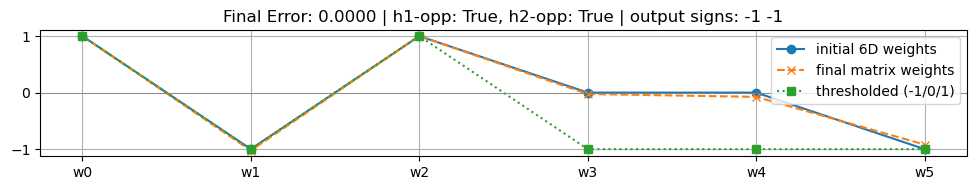

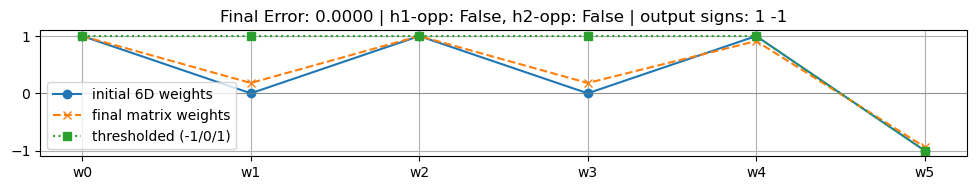

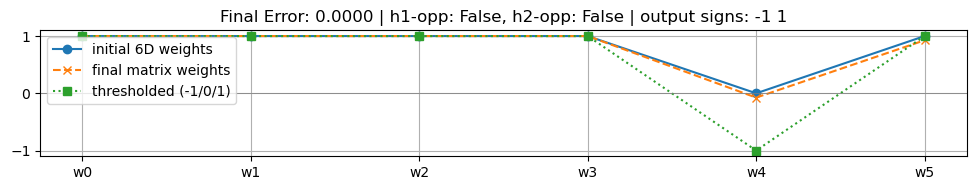

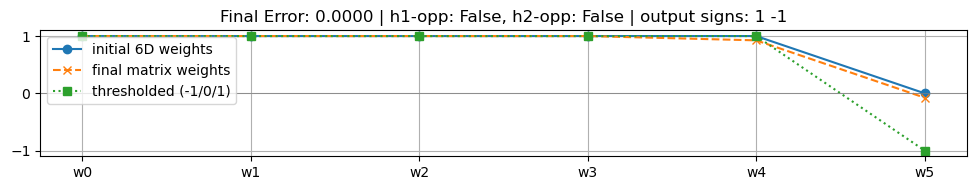

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

for initial_weights, (final_error, w_in, w_out) in [(k, errors[k]) for k in errors if errors[k][0] < 0.001]:
    w_in = w_in.numpy()
    w_out = w_out.numpy()
    
    # Flatten and concatenate final weights
    final_weights = np.concatenate([w_in.flatten(), w_out.flatten()])
    
    # Apply threshold: map to {-1, 0, 1}
    thresholded = np.zeros_like(final_weights)
    thresholded[final_weights > 0.0005] = 1
    thresholded[final_weights < -0.0005] = -1

    # Opposing signs check for each hidden unit
    opp_hidden_1 = np.sign(w_in[0, 0]) != np.sign(w_in[0, 1])
    opp_hidden_2 = np.sign(w_in[1, 0]) != np.sign(w_in[1, 1])

    # Output signs
    output_signs = np.sign(w_out.flatten()).astype(int)
    output_flag = "output signs: " + " ".join(map(str, output_signs))
    pair_flag = f"h1-opp: {opp_hidden_1}, h2-opp: {opp_hidden_2}"

    # Plotting
    plt.figure(figsize=(10, 2))
    plt.plot(initial_weights.numpy(), label="initial 6D weights", marker='o')
    plt.plot(final_weights, label="final matrix weights", linestyle='--', marker='x')
    plt.plot(thresholded, label="thresholded (-1/0/1)", linestyle=':', marker='s')

    plt.title(f"Final Error: {final_error:.4f} | {pair_flag} | {output_flag}")
    plt.xticks(ticks=range(6), labels=[f'w{i}' for i in range(6)])
    plt.axhline(0, color='gray', linewidth=0.5)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
import torch
import matplotlib.pyplot as plt

for item in [(k, errors[k]) for k in errors if errors[k][0] < 0.001]:
    initial_weights = item[0]                # 6D vector
    final_error, w_in, w_out = item[1]

    # Flatten and concatenate hidden & output weights
    final_weights = np.array(torch.cat([w_in.flatten(), w_out.flatten()]))
    
    plt.figure(figsize = (10,1))
    # Plot original 6D vector
    plt.plot(initial_weights.numpy(), label="6D weights")

    # Plot unrolled full matrix weights (optional)
    plt.plot(final_weights.numpy(), label="matrix weights")

    # Print raw values
    # print("Raw tuple:", item)
    # print("Unrolled:", full_matrix_weights.tolist())

    plt.legend()
    plt.show()
    # break  # only first


TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

(tensor([-1.,  0.,  0., -1.,  1.,  1.]), (0.0, tensor([[-1.0125,  0.0125],
        [ 0.0125, -1.0125]]), tensor([[1.0000],
        [1.0000]])))
[tensor([-1.0125,  0.0125]), tensor([ 0.0125, -1.0125]), tensor([1.0000]), tensor([1.0000])]


/var/folders/q0/hw11rnjs0g1cnny7p5swsnv40000gn/T/ipykernel_41981/448095749.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


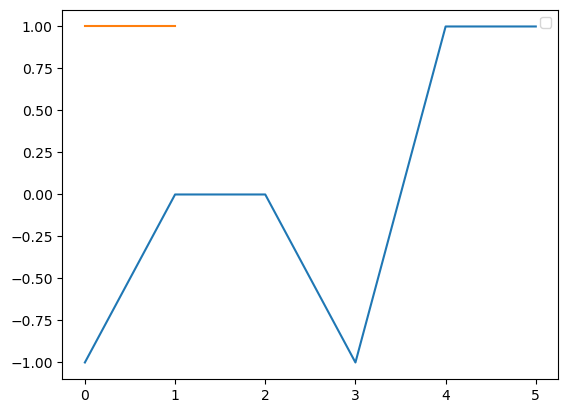

In [ ]:
for item in [(k, errors[k]) for k in errors if errors[k][0] < 0.001]:
    plt.plot(item[0])
    plt.plot(item[1][-1])
    print(item)
    print(list(item[1][-2]) + list(item[1][-1]))
    # print(item[1][0])
    plt.legend()
    plt.show()
    break

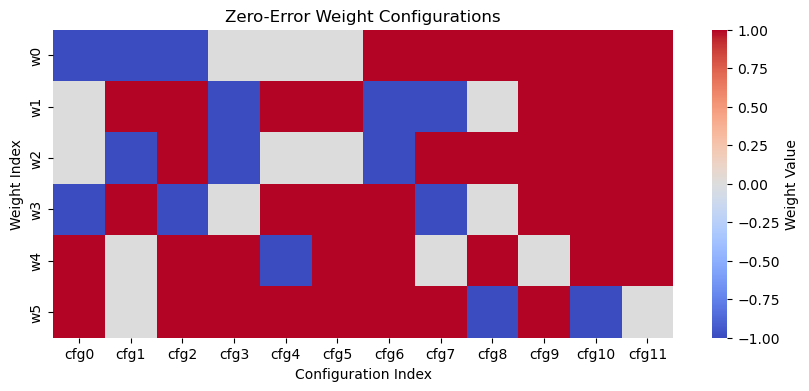

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Plot as a heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(zero_error_weights.T, cmap='coolwarm', center=0,
            xticklabels=[f'cfg{i}' for i in range(zero_error_weights.shape[0])],
            yticklabels=[f'w{i}' for i in range(zero_error_weights.shape[1])],
            cbar_kws={"label": "Weight Value"})
plt.title("Zero-Error Weight Configurations")
plt.xlabel("Configuration Index")
plt.ylabel("Weight Index")
plt.show()


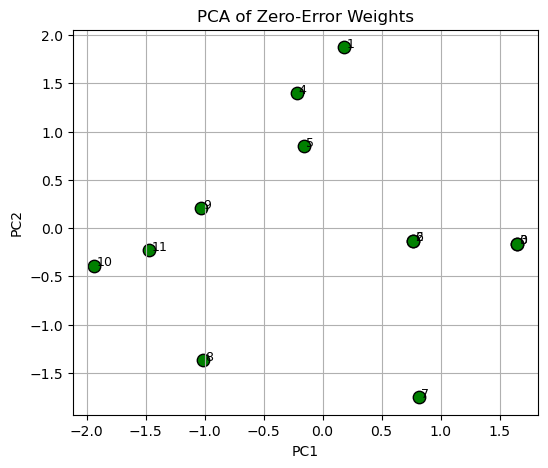

In [ ]:
from sklearn.decomposition import PCA

# Convert to numpy
X = zero_error_weights.numpy()
pca = PCA(n_components=2)
proj = pca.fit_transform(X)

plt.figure(figsize=(6, 5))
plt.scatter(proj[:, 0], proj[:, 1], c='green', s=80, edgecolors='black')
for i, (x, y) in enumerate(proj):
    plt.text(x + 0.02, y, str(i), fontsize=9)
plt.title("PCA of Zero-Error Weights")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


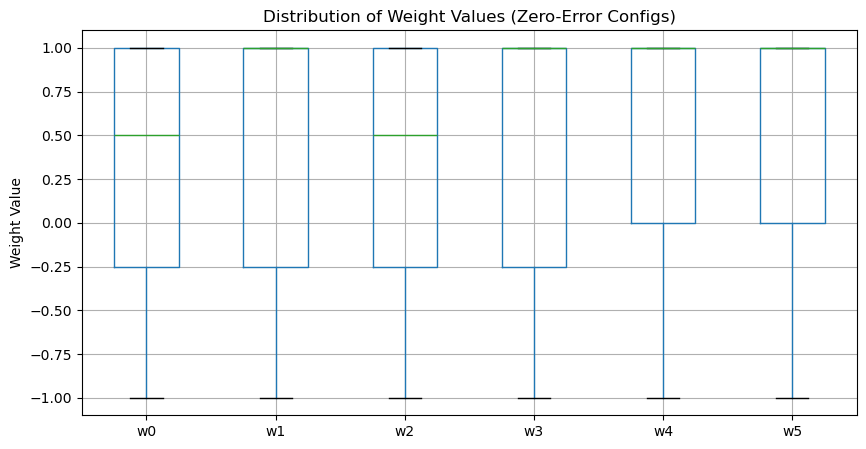

In [ ]:
import pandas as pd

df = pd.DataFrame(zero_error_weights.numpy(), columns=[f'w{i}' for i in range(6)])
plt.figure(figsize=(10, 5))
df.boxplot()
plt.title("Distribution of Weight Values (Zero-Error Configs)")
plt.ylabel("Weight Value")
plt.grid(True)
plt.show()


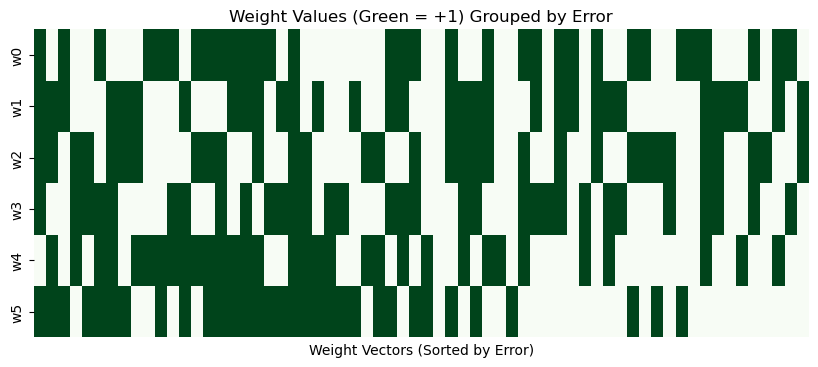

In [ ]:
import seaborn as sns

# Create DataFrame for heatmap
df_bin = pd.DataFrame(initial_weights, columns=[f'w{i}' for i in range(6)])
df_bin['error'] = errors
df_bin['error_label'] = df_bin['error'].astype(str)

# Sort by error
df_bin_sorted = df_bin.sort_values('error')
heat_data = df_bin_sorted.drop(columns=['error', 'error_label'])

plt.figure(figsize=(10, 4))
sns.heatmap((heat_data == 1).T, cmap='Greens', cbar=False, xticklabels=False)
plt.yticks(np.arange(6)+0.5, heat_data.columns)
plt.title("Weight Values (Green = +1) Grouped by Error")
plt.xlabel("Weight Vectors (Sorted by Error)")
plt.show()


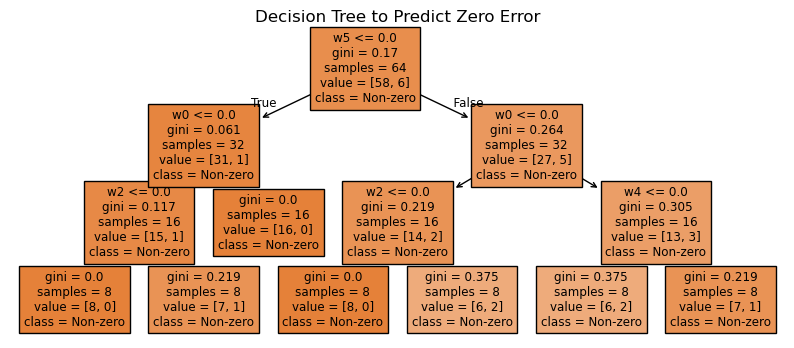

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

X = initial_weights
y = (errors <=0.1).astype(int)  # binary target: 1 if error == 0

clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X, y)

plt.figure(figsize=(10, 4))
plot_tree(clf, feature_names=[f'w{i}' for i in range(6)], class_names=["Non-zero", "Zero"], filled=True)
plt.title("Decision Tree to Predict Zero Error")
plt.show()


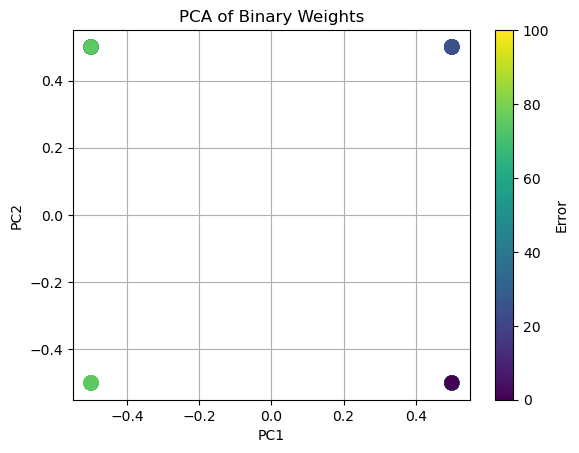

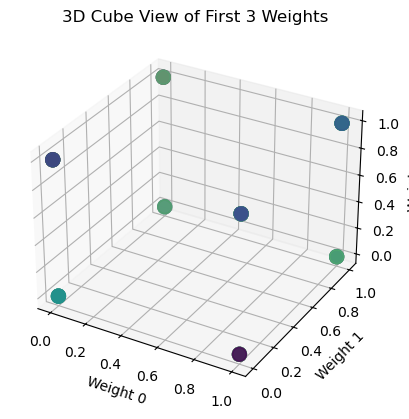

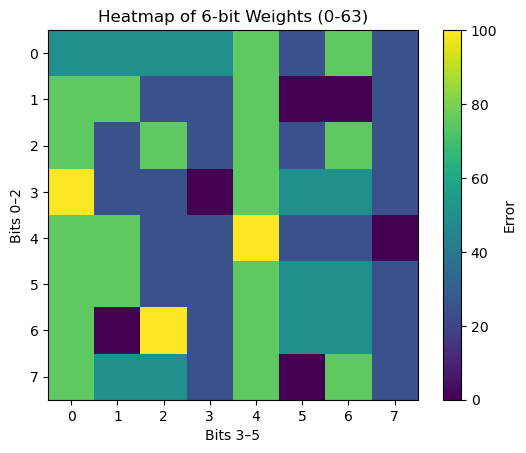

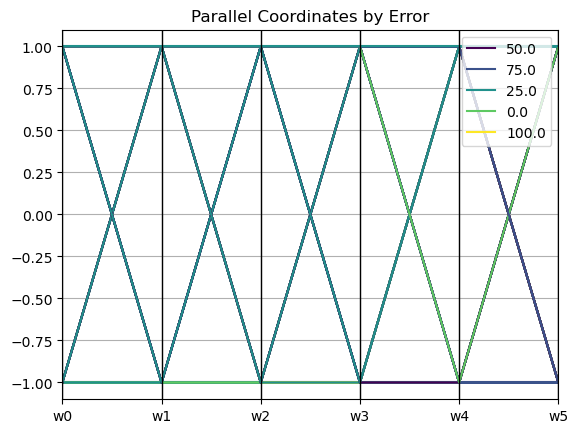

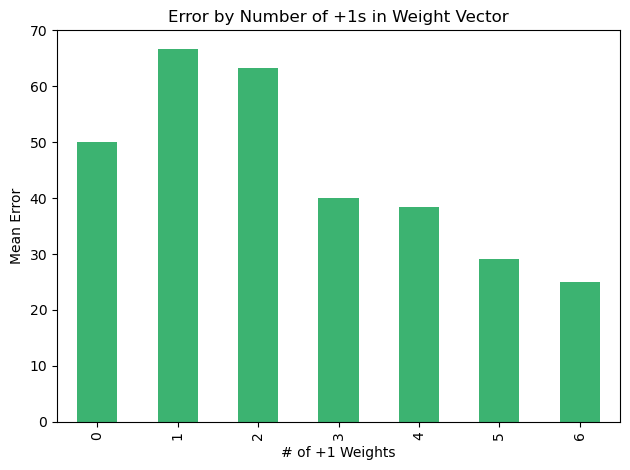

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from pandas.plotting import parallel_coordinates
from mpl_toolkits.mplot3d import Axes3D

# XOR binary weights to final error
raw_data = errors 
initial_weights = np.array(list(raw_data.keys()))
errors = np.array(list(raw_data.values()))
binary = ((initial_weights + 1) / 2).astype(int)

# 1. PCA Plot
pca = PCA(n_components=2)
pca_proj = pca.fit_transform(binary)

plt.figure()
plt.scatter(pca_proj[:, 0], pca_proj[:, 1], c=errors, cmap='viridis', s=100)
plt.colorbar(label='Error')
plt.title('PCA of Binary Weights')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)

# 2. 3D Projection
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(binary[:, 0], binary[:, 1], binary[:, 2], c=errors, cmap='viridis', s=100)
ax.set_xlabel('Weight 0')
ax.set_ylabel('Weight 1')
ax.set_zlabel('Weight 2')
plt.title('3D Cube View of First 3 Weights')

# 3. Heatmap of All 64 Configs
heatmap = np.full((64,), np.nan)
for i, b in enumerate(binary):
    idx = int("".join(b.astype(str)), 2)
    heatmap[idx] = errors[i]
heatmap_reshaped = heatmap.reshape(8, 8)

plt.figure()
plt.imshow(heatmap_reshaped, cmap='viridis', vmin=0, vmax=100)
plt.colorbar(label='Error')
plt.title('Heatmap of 6-bit Weights (0-63)')
plt.xlabel('Bits 3–5')
plt.ylabel('Bits 0–2')

# 4. Parallel Coordinates
df = pd.DataFrame(initial_weights, columns=[f'w{i}' for i in range(6)])
df['error'] = errors
plt.figure()
parallel_coordinates(df, 'error', colormap='viridis')
plt.title("Parallel Coordinates by Error")

# 5. Histogram by # of +1 Weights
num_pos_ones = (initial_weights == 1).sum(axis=1)
df_hist = pd.DataFrame({'num_pos_ones': num_pos_ones, 'error': errors})
mean_errors = df_hist.groupby('num_pos_ones')['error'].mean()

plt.figure()
mean_errors.plot(kind='bar', color='mediumseagreen')
plt.xlabel('# of +1 Weights')
plt.ylabel('Mean Error')
plt.title('Error by Number of +1s in Weight Vector')

plt.tight_layout()
plt.show()
